In [1]:
### FILL THESE VALUES ###

PATH_TO_REPO = '/home/eco03/github/utae-paps/'
PATH_TO_DATA = '/home/eco03/DATA/PASTIS/'
PATH_TO_UTAE_WEIGHTS = '/home/eco03/DATA/UTAE_zenodo/'
PATH_TO_UTAEPaPs_WEIGHTS = '/home/eco03/DATA/UTAE_PAPs/'
device = 'cuda' # or "cpu"

#######


import torch
import json
import os
from argparse import Namespace

import matplotlib.pyplot as plt
from matplotlib.colors import Colormap, ListedColormap
import matplotlib

from matplotlib import patches
import numpy as np
import sys
sys.path.append(PATH_TO_REPO) 


from src.backbones.utae import UTAE
from src.panoptic.paps import PaPs
from src.dataset import PASTIS_Dataset
from train_panoptic import recursive_todevice
from src.utils import pad_collate
from src.model_utils import get_model

from captum.attr import IntegratedGradients
from sklearn.linear_model import LinearRegression

import cv2

import warnings
warnings.filterwarnings('ignore')


# Colormap (same as in the paper)
cm = matplotlib.cm.get_cmap('tab20')
def_colors = cm.colors
cus_colors = ['k'] + [def_colors[i] for i in range(1,19)]+['w']
cmap = ListedColormap(colors = cus_colors, name='agri',N=20)


from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
redgreen = LinearSegmentedColormap.from_list("shap", colors)

label_names = [
"Background",
"Meadow",
"Soft winter wheat",
"Corn",
"Winter barley",
"Winter rapeseed",
"Spring barley",
"Sunflower",
"Grapevine",
"Beet",
 "Winter triticale",
 "Winter durum wheat",
 "Fruits,  vegetables, flowers",
 "Potatoes",
 "Leguminous fodder",
 "Soybeans",
 "Orchard",
 "Mixed cereal",
 "Sorghum",
 "Void label"]


def load_model(path, device, fold=1, mode='semantic', add_args=None):
    """Load pre-trained model"""
    with open(os.path.join(path, 'conf.json')) as file:
        config = json.loads(file.read())
        
    if add_args is not None:
        config = {**config, **add_args}
    config = Namespace(**config)
    model = get_model(config, mode = mode).to(device)

    sd = torch.load(
        os.path.join(path, "Fold_{}".format(fold+1), "model.pth.tar"),
        map_location=device
        )
    model.load_state_dict(sd['state_dict'])
    
    
    return model

def get_rgb(x,b=0,t_show=6):
    """Gets an observation from a time series and normalises it for visualisation."""
    im = x[b,t_show,[2,1,0]].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

In [2]:
# Load dataset and models

fold = 3
batch_size = 2
dt = PASTIS_Dataset(folder=PATH_TO_DATA, norm=True,
                target='instance', folds=[fold],)
dl = torch.utils.data.DataLoader(dt, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
iterator =  dl.__iter__()
device = torch.device(device)


utae = load_model(PATH_TO_UTAE_WEIGHTS, device=device, fold=fold, mode='semantic', add_args=dict(positional_encoding=False)).eval()

Reading patch metadata . . .
Done.
Dataset ready.


In [15]:
batch = recursive_todevice(iterator.__next__(), device)
(x, dates), y = batch

In [18]:
ig = IntegratedGradients(utae.eval())

## Baseline: 
#B,T,C,H,W = x.shape
#baselines = dt.norm['S2'][0].unsqueeze(0).unsqueeze(0).unsqueeze(-1).unsqueeze(-1).to(device)
#baselines = baselines.repeat((B,T,1,H,W))
baselines = torch.zeros(x.shape,device=device)

target = y[:,:,:,-1]
n = 1 
t = 30
h = 32


pixel_i = 15
pixel_j = 20
pixel_class = target[0, pixel_i, pixel_j].long()

torch.cuda.empty_cache()
attributions = ig.attribute(inputs=x[:n,:t,:,:h,:h], baselines=baselines[:n,:t,:,:h,:h], target=(pixel_class, pixel_i, pixel_j), additional_forward_args=dates[:n,:t])

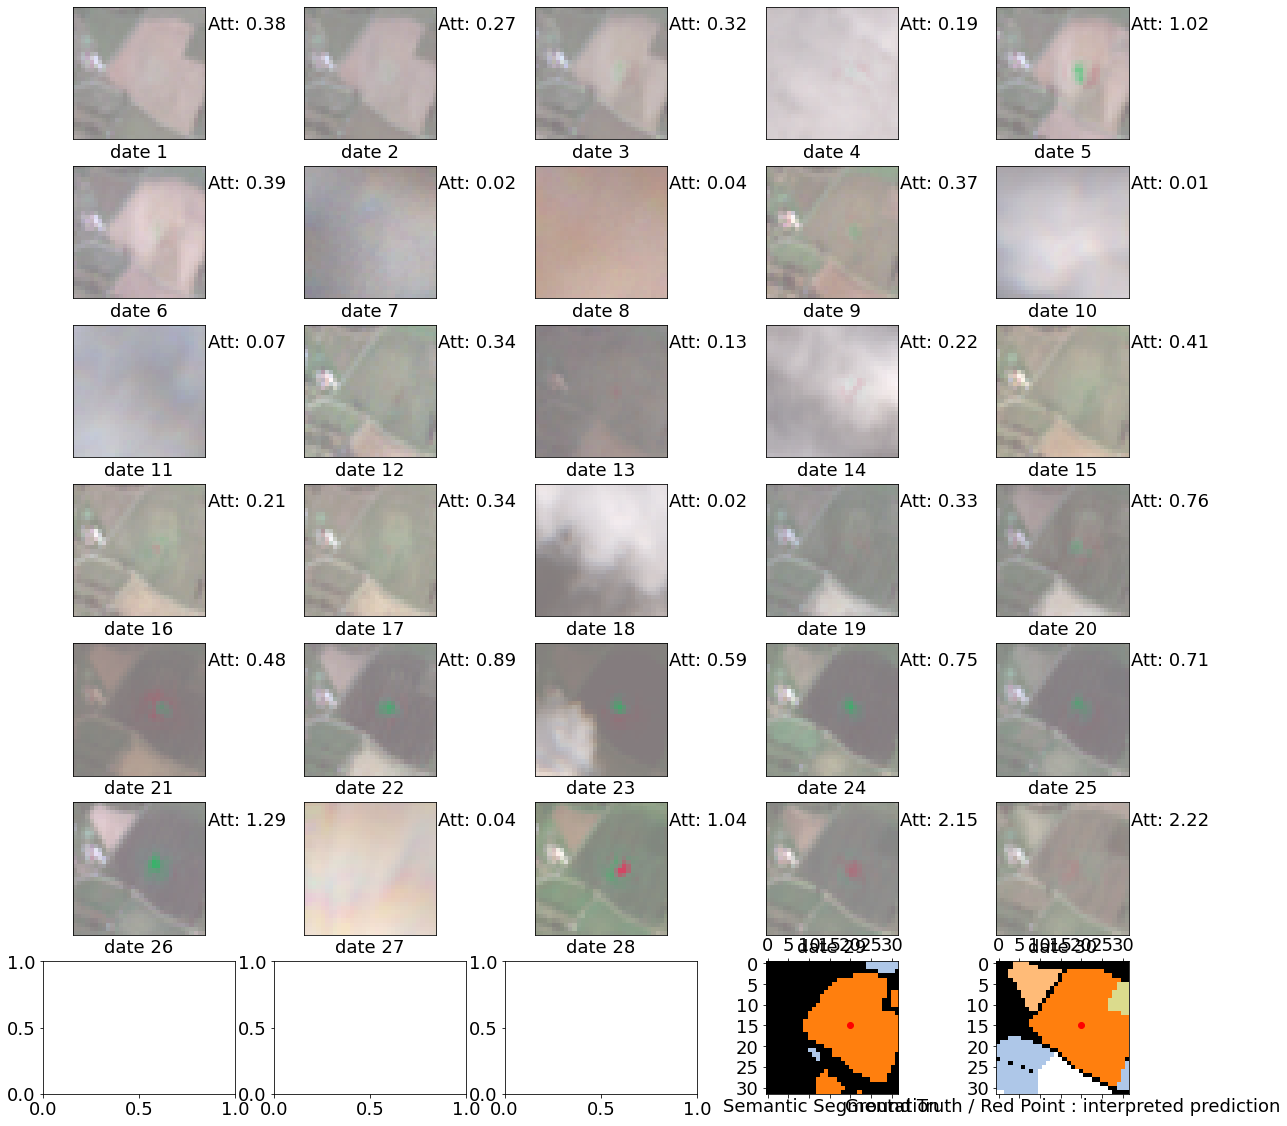

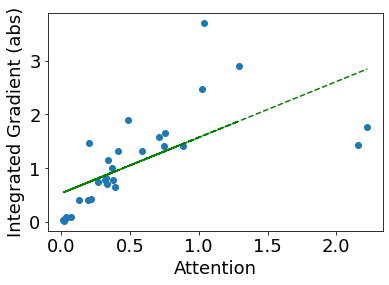

In [23]:
with torch.no_grad():
    sempred , attention = utae(x[:1,:t], batch_positions=dates[:1,:t], return_att=True)
    
sempred = sempred.argmax(dim=1)[0].cpu()
at = attributions[0].sum(dim=1).cpu()
at_max = at.max()
at_min = at.min()


cum_attention = attention[:,0,:, pixel_i//8, pixel_j//8].sum(0)

matplotlib.rcParams.update({'font.size': 18})

gt = y[0,:,:,-1].cpu()
clas = gt[pixel_i, pixel_j]

fig, axes = plt.subplots((t//5) + 1,5, figsize=(20,20))
axes = axes.ravel()

for i in range(t):
    axes[i].imshow(get_rgb(x, b=0, t_show=i)[:h,:h], alpha=.5)
    t_plot = at[i]
    #t_plot[abs(t_plot)<0.01] = np.nan
    
    axes[i].imshow(t_plot, cmap=redgreen, alpha=.7, vmin=at_min, vmax=at_max)
    axes[i].set_xlabel(f'date {i+1}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].text(32,5, 'Att: {:.2f}'.format(cum_attention[i]))


    
axes[-1].matshow(y[0,:h,:h,-1].cpu(), cmap=cmap, vmin=0, vmax=19)
axes[-1].set_xlabel('Ground Truth / Red Point : interpreted prediction')
axes[-2].set_xlabel('Semantic Segmentation')


axes[-2].matshow(sempred[:h,:h], cmap=cmap, vmin=0, vmax=19)
axes[-1].scatter(pixel_j, pixel_i,marker='o',color='r')
axes[-2].scatter(pixel_j, pixel_i,marker='o',color='r')


plt.show()


fig, ax = plt.subplots()
ca = cum_attention.cpu().numpy()
exp = at.abs().sum((1,2)).cpu().numpy()
ax.scatter(cum_attention.cpu(),at.abs().sum((1,2)).cpu())
ax.set_xlabel('Attention')
ax.set_ylabel('Integrated Gradient (abs)')

lr = LinearRegression()
lr.fit(ca.reshape(-1, 1), exp.reshape(-1, 1))
line = (lr.intercept_ + lr.coef_ * ca).reshape(-1)

#m = torch.cat([cum_attention.cpu(), at.sum((1,2)).abs()]).max().cpu()
ax.plot(ca, line, color='g', linestyle='--')

plt.show()



### Spatio-temporal explanation visualisation

In [49]:
attributions.shape

torch.Size([1, 30, 10, 32, 32])

In [20]:
B,T,C,H,W = attributions.shape

distance_mask = np.zeros((H,W), dtype=int)
for i in range(H):
    for j in range(W):
        distance_mask[i,j] = int(abs(i - pixel_i) + abs(j - pixel_j))
        
distances = np.unique(distance_mask)

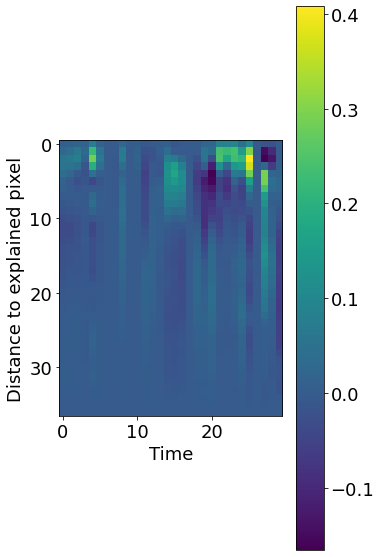

In [21]:
a = attributions[0].sum(1) #TxHxW
stat = []


for d in distances:
    mask = distance_mask==d
    values = a[:,mask]
    stat.append(values.sum(-1))

stat = torch.stack(stat)

fig, ax = plt.subplots(figsize=(5,10))
plt.colorbar(ax.imshow(stat.cpu()))
ax.set_ylabel('Distance to explained pixel')
ax.set_xlabel('Time')
plt.show()